## ロジスティック回帰で、データ学習

検証対象事項
- goodのデータとbadのデータの数をそろえることにより、どのような効果があるか確認する

In [1]:
%matplotlib inline

In [3]:
import MeCab

m = MeCab.Tagger("-Owakati")
def tokenizer_mecab(sentence):
    kekka = m.parse(sentence)
    return kekka.split(" ")

#Mecabは学習のときにのみ使用
#IPA辞書は入れているが、neologdは入れていない

In [4]:
from janome.tokenizer import Tokenizer

t = Tokenizer()
def tokenizer_janome(sentence):
    return t.tokenize(sentence, wakati = True)

#pythonanywhereにMeCabインストール方法が分からなかったため、
#性能評価とpythonanywhereにはこちらを使用

In [5]:
import pandas as pd
import numpy as np

#csvファイルからデータ読み込み、加工
review = pd.read_csv("data_20181013.csv",names=('comment','star'))
review = review[review['star'] != '-']
review['star'] = review['star'].astype(np.float)

In [6]:
review.describe()

,star
count,389608.000000
mean,3.784372
std,0.654459
min,1.000000
25%,3.500000
50%,3.800000
75%,4.200000
max,5.000000


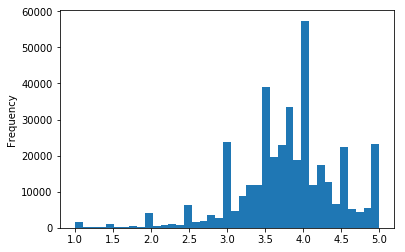

In [7]:
review['star'].plot.hist(bins=39)

実際にレビューを見て、星の数と良い評価・悪い評価の感覚を探る  
2.9以下：大多数が悪い評価  
3.0～3.5：いい評価・悪い評価がまざりあっている  
3.6以上：大多数が良い評価  

## <font color="Red">badの件数が少ないため、goodの件数を4.6以上にしgoodの件数を減らすことで、件数をだいたい一致させる</font>

In [8]:
#高評価or低評価のレビューのみ残す（上の分布を見て、良いとも悪いともつかない中間部分のデータは捨てる）
review_sel1 = review[review['star'] < 3.0]
#review_sel2 = review[review['star'] > 3.5]
review_sel2 = review[review['star'] > 4.5]
review_sel = pd.concat([review_sel1,review_sel2])
review_sel['star'] = np.where(review_sel['star'] > 3.3, 1, 0)

In [9]:
review_sel.describe()

,star
count,66154.000000
mean,0.581386
std,0.493336
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
from sklearn.model_selection import train_test_split

#訓練用とテスト用にデータを分ける
X_train, X_test, y_train, y_test \
    = train_test_split(review_sel['comment'].values, review_sel['star'].values, \
    test_size=0.1, random_state=1, stratify=review_sel['star'])

In [11]:
from sklearn.feature_extraction.text import  CountVectorizer, TfidfTransformer

#ベクトルの準備
count = CountVectorizer(tokenizer=tokenizer_mecab)
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)

from sklearn.pipeline import Pipeline
#パイプライン作成
pipe_lr = Pipeline([('count', count), \
                     ('vect', tfidf), \
                     ('clf', lr)])

In [13]:
#グリッドサーチのためにパラメータキー確認
pipe_lr.get_params().keys()

dict_keys(['memory', 'steps', 'count', 'vect', 'clf', 'count__analyzer', 'count__binary', 'count__decode_error', 'count__dtype', 'count__encoding', 'count__input', 'count__lowercase', 'count__max_df', 'count__max_features', 'count__min_df', 'count__ngram_range', 'count__preprocessor', 'count__stop_words', 'count__strip_accents', 'count__token_pattern', 'count__tokenizer', 'count__vocabulary', 'vect__norm', 'vect__smooth_idf', 'vect__sublinear_tf', 'vect__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [15]:
from sklearn.model_selection import GridSearchCV

#グリッドサーチ作成
#n_jobsに-1をセットすると、tokenizerについてcan t get attributエラーが出る
param_grid = [{'clf__C':[0.1,1.0,10,100]}]
gs = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,return_train_score=True,
                  scoring=None,
                  cv=2)

In [16]:
gs.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf__C': [0.1, 1.0, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
print(gs.best_score_)
print(gs.best_params_)

0.855839967751688
{'clf__C': 1.0}


In [18]:
results = pd.DataFrame(gs.cv_results_)
display(results.T)

,0,1,2,3
mean_fit_time,4.52723,4.7214,5.27817,6.23868
std_fit_time,0.0523281,0.0609918,0.160951,0.230143
mean_score_time,3.87599,4.32016,3.92311,3.7195
std_score_time,0.049351,0.0719167,0.118296,0.136401
param_clf__C,0.1,1,10,100
params,{'clf__C': 0.1},{'clf__C': 1.0},{'clf__C': 10},{'clf__C': 100}
split0_test_score,0.822405,0.853342,0.852906,0.833121
split1_test_score,0.825887,0.858338,0.855684,0.835528
mean_test_score,0.824146,0.85584,0.854295,0.834324
std_test_score,0.00174088,0.00249776,0.00138917,0.00120375


### パラメータを絞ってgridsearch再実施

In [19]:
param_grid = [{'clf__C':[0.8,2,3,4,5,6,7,8],'count__tokenizer':[tokenizer_mecab]}]
gs2 = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,return_train_score=True,
                  scoring=None,
                  cv=2)

In [20]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf__C': [0.8, 2, 3, 4, 5, 6, 7, 8], 'count__tokenizer': [<function tokenizer_mecab at 0x000001194A6E7AE8>]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
print(gs2.best_score_)
print(gs2.best_params_)

0.8591991669186066
{'clf__C': 3, 'count__tokenizer': <function tokenizer_mecab at 0x000001194A6E7AE8>}


In [22]:
results = pd.DataFrame(gs2.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7
mean_fit_time,4.51283,4.57682,4.45505,4.75465,4.75465,4.80127,4.95057,4.96768
std_fit_time,0.0508559,0.0270479,0.0327204,0.0952322,0.0431523,0.0287691,0.0763829,0.000248194
mean_score_time,3.61583,3.66221,3.70065,3.55756,3.90103,3.55631,3.79663,3.72497
std_score_time,0.0218232,0.118295,0.118048,0.00272834,0.2108,0.00595391,0.219977,0.0242877
param_clf__C,0.8,2,3,4,5,6,7,8
param_count__tokenizer,<function tokenizer_mecab at 0x000001194A6E7AE8>,<function tokenizer_mecab at 0x000001194A6E7AE8>,<function tokenizer_mecab at 0x000001194A6E7AE8>,<function tokenizer_mecab at 0x000001194A6E7AE8>,<function tokenizer_mecab at 0x000001194A6E7AE8>,<function tokenizer_mecab at 0x000001194A6E7AE8>,<function tokenizer_mecab at 0x000001194A6E7AE8>,<function tokenizer_mecab at 0x000001194A6E7AE8>
params,"{'clf__C': 0.8, 'count__tokenizer': <function ...","{'clf__C': 2, 'count__tokenizer': <function to...","{'clf__C': 3, 'count__tokenizer': <function to...","{'clf__C': 4, 'count__tokenizer': <function to...","{'clf__C': 5, 'count__tokenizer': <function to...","{'clf__C': 6, 'count__tokenizer': <function to...","{'clf__C': 7, 'count__tokenizer': <function to...","{'clf__C': 8, 'count__tokenizer': <function to..."
split0_test_score,0.852402,0.857205,0.857776,0.85697,0.856466,0.855727,0.855223,0.854316
split1_test_score,0.857464,0.860454,0.860622,0.859749,0.858741,0.858439,0.857733,0.857028
mean_test_score,0.854933,0.85883,0.859199,0.858359,0.857604,0.857083,0.856478,0.855672


In [23]:
#グリッドサーチで取得したパラメータを使用し、新たにパイプライン作成

from sklearn.linear_model import LogisticRegression
lr3 = LogisticRegression(random_state=1,C=3)

from sklearn.pipeline import Pipeline
pipe_lr3 = Pipeline([('count', count), \
                     ('vect', tfidf), \
                     ('clf', lr3)])

In [24]:
pipe_lr3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [25]:
#性能検証用にtokenizerをjanomeに変更
pipe_lr3.set_params(count__tokenizer=tokenizer_janome)

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [26]:
print(pipe_lr3.score(X_test, y_test))

0.8621523579201935


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
pred_y = pipe_lr3.predict(X_test)
confusion = confusion_matrix(y_test, pred_y)
cl_report = classification_report(y_test, pred_y, target_names=['bad', 'good'])
print(confusion)
print(cl_report)

[[2140  630]
 [ 282 3564]]
             precision    recall  f1-score   support

        bad       0.88      0.77      0.82      2770
       good       0.85      0.93      0.89      3846

avg / total       0.86      0.86      0.86      6616



In [29]:
#比較用にtokenizerがmecabのままの場合の性能を評価
pipe_lr3.set_params(count__tokenizer=tokenizer_mecab)
print(pipe_lr3.score(X_test, y_test))

0.8641172914147521


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
pred_y = pipe_lr3.predict(X_test)
confusion = confusion_matrix(y_test, pred_y)
cl_report = classification_report(y_test, pred_y, target_names=['bad', 'good'])
print(confusion)
print(cl_report)

[[2275  495]
 [ 404 3442]]
             precision    recall  f1-score   support

        bad       0.85      0.82      0.84      2770
       good       0.87      0.89      0.88      3846

avg / total       0.86      0.86      0.86      6616



mecabのほうが性能はいいが、janomeに変更しても全く使えないほどの性能悪化は見られない

## 学習曲線を描いて、現状分析

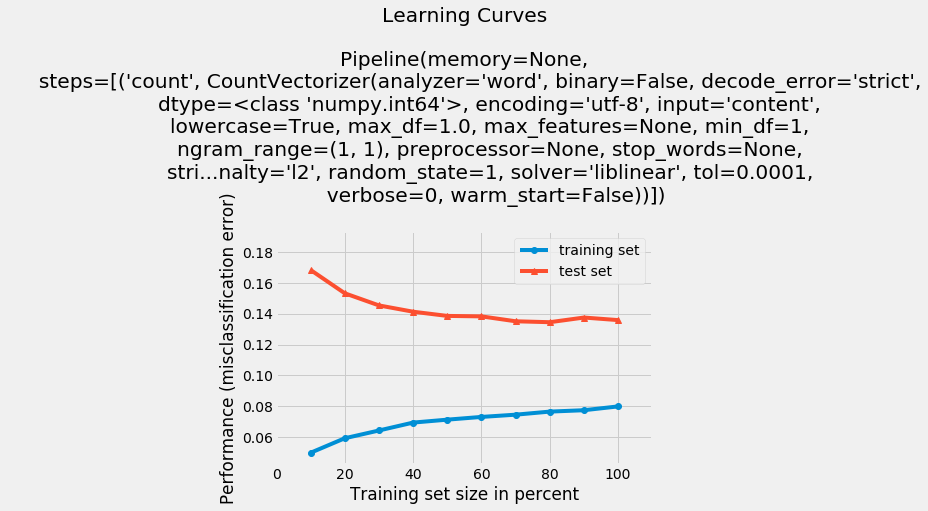

In [31]:
#C=3のときの学習曲線を描く

from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt

count4 = CountVectorizer(tokenizer=tokenizer_mecab)
tfidf4 = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
lr4 = LogisticRegression(random_state=1,C=3)
pipe_lr4 = Pipeline([('count', count4), \
                    ('vect', tfidf4), \
                    ('clf', lr4)])
plot_learning_curves(X_train, y_train, X_test, y_test, pipe_lr4)
plt.show()

## <font color="Red">学習曲線の結果より、さらなるデータ収集が必要と判断</font>

### 以下はサンプルデータで適切に判断できているか実験（'0'=bad, '1'=good）

In [34]:
pipe_lr3.set_params(count__tokenizer=tokenizer_mecab)

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [35]:
pipe_lr3.predict(['好き','大好き','最高','楽しい','面白い','良い','爽快','傑作','感動','涙','笑える','笑い','何度も見たい','深い','上手'])

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0])

In [36]:
pipe_lr3.predict(['かわいい','かっこいい','天才的','美しい'])

array([0, 1, 0, 0])

In [37]:
pipe_lr3.predict(['ひどい','最低','最悪','嫌い','ダメ','駄作','つまらない','退屈','好きじゃない','見るに堪えない','下手','浅い'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
pipe_lr3.predict(['二度と見たくない','大根役者','くだらない','ありきたり','気分が悪くなる',''])

array([0, 0, 0, 0, 0, 0])

## 学習結果をpickleに出力

In [39]:
#そのままpythonanywhereに上げると、tokenizerが見つからないとエラーになるため、一度Noneにする
pipe_lr3.set_params(count__tokenizer=None)

import pickle
import os
dest = os.path.join('.','pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(pipe_lr3,  \
            open(os.path.join(dest, 'pipe_lr3.pkl'), 'wb'), \
            protocol=4)